# Airbus Ship Detection Challenge
Find ships on satellite images as quickly as possible
https://www.kaggle.com/c/airbus-ship-detection/overview/evaluation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.metrics import error_rate
import pandas as pd

In [3]:
path = Config.data_path()/'airbus-ship-detection'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/storage/airbus-ship-detection')

In [4]:
#! kaggle competitions download -c airbus-ship-detection -p {path} 

In [5]:
! ls {path}

sample_submission_v2.csv  train_ship_segmentations_v2.csv  train_v2
test_v2			  train_small


In [6]:
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted image

In [12]:
train_img_path = path/'train_v2'

In [13]:
for exclude in exclude_list:
    ! rm {train_img_path}'/'{exclude}

rm: cannot remove '/storage/airbus-ship-detection/train_v2/6384c3e78.jpg': No such file or directory
rm: cannot remove '/storage/airbus-ship-detection/train_v2/13703f040.jpg': No such file or directory
rm: cannot remove '/storage/airbus-ship-detection/train_v2/14715c06d.jpg': No such file or directory
rm: cannot remove '/storage/airbus-ship-detection/train_v2/33e0ff2d5.jpg': No such file or directory
rm: cannot remove '/storage/airbus-ship-detection/train_v2/4d4e09f2a.jpg': No such file or directory
rm: cannot remove '/storage/airbus-ship-detection/train_v2/877691df8.jpg': No such file or directory
rm: cannot remove '/storage/airbus-ship-detection/train_v2/8b909bb20.jpg': No such file or directory
rm: cannot remove '/storage/airbus-ship-detection/train_v2/a8d99130e.jpg': No such file or directory
rm: cannot remove '/storage/airbus-ship-detection/train_v2/ad55c3143.jpg': No such file or directory
rm: cannot remove '/storage/airbus-ship-detection/train_v2/c8260c541.jpg': No such file or 

In [14]:
train_mask = pd.read_csv(path/'train_ship_segmentations_v2.csv'); train_mask.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

## remove duplicates by image id

In [15]:
train_mask.drop_duplicates(subset=['ImageId'], inplace=True)

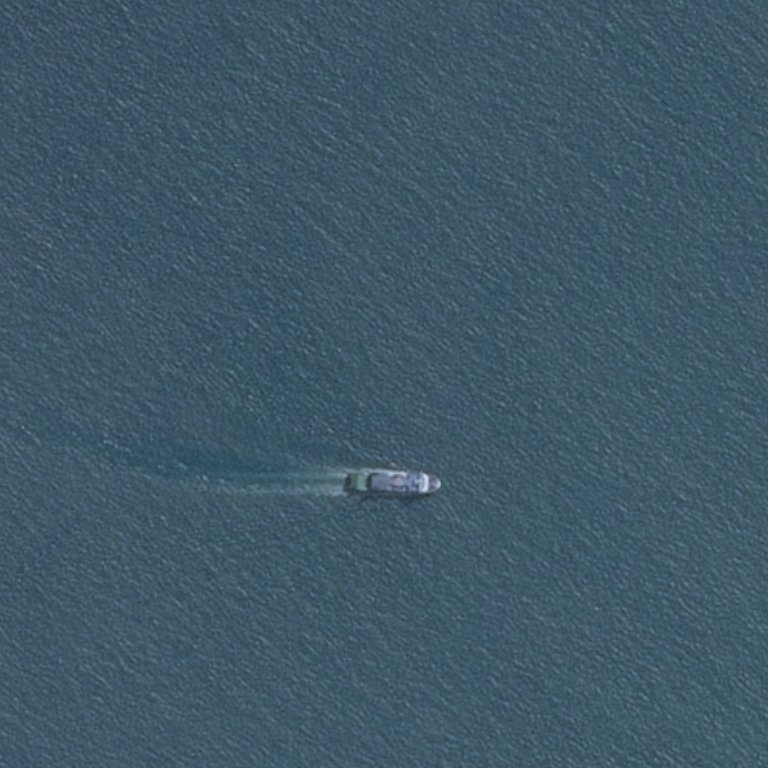

In [16]:
img = open_image(train_img_path/train_mask.iloc[2]['ImageId'])
img

In [17]:
img.size

torch.Size([768, 768])

In [18]:
def open_mask_rle_vert(mask_rle:str, shape:Tuple[int, int])->ImageSegment:
    x = FloatTensor(rle_decode(str(mask_rle), shape).astype(np.uint8))
    x = x.view(shape[1], shape[0], -1)
    return ImageSegment(x.permute(2,1,0))

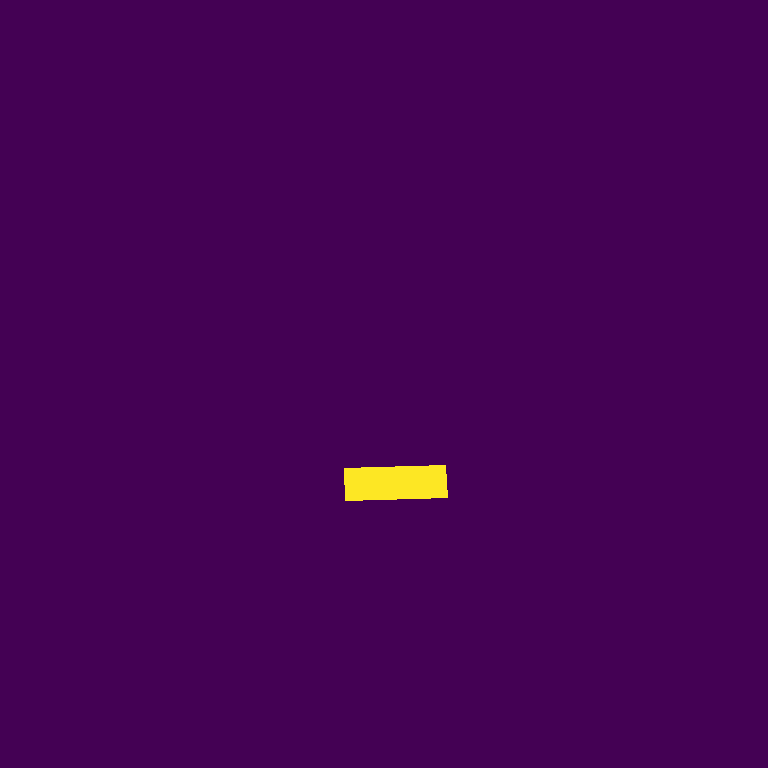

In [19]:
mask = open_mask_rle_vert(train_mask.iloc[2]['EncodedPixels'], shape=(768, 768)); mask

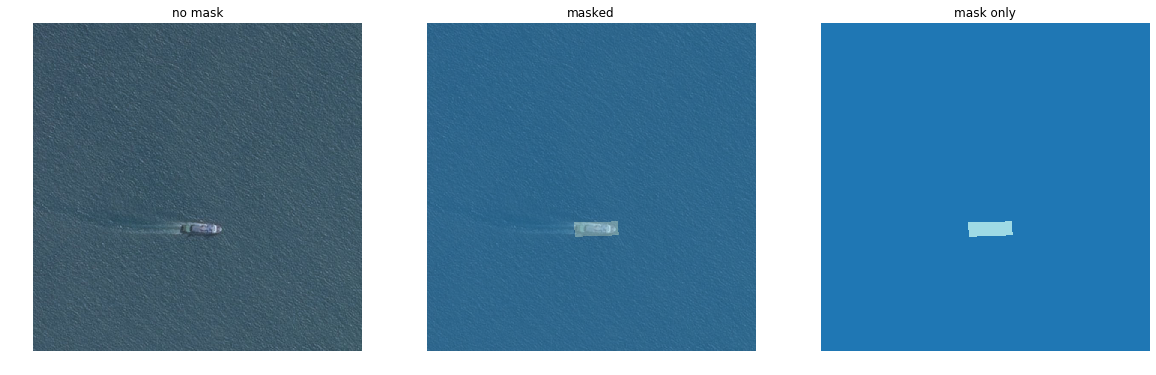

In [20]:
id = 2
img = open_image(train_img_path/train_mask.iloc[id]['ImageId'])
mask = open_mask_rle_vert(train_mask.iloc[id]['EncodedPixels'], shape=(768, 768))
_,axs = plt.subplots(1,3, figsize=(20,20))
img.show(ax=axs[0], title='no mask')
img.show(ax=axs[1], y=mask, title='masked')
mask.show(ax=axs[2], title='mask only', alpha=1.)

In [21]:
src_size = np.array(mask.shape[1:]);src_size

array([768, 768])

In [22]:
original_shape = 768

In [32]:
size = 384

## Play with mask

In [33]:
train_mask_img_indexed = train_mask.set_index('ImageId');

In [34]:
train_mask_img_indexed.head()

EncodedPixels
ImageId                                                         
00003e153.jpg                                                NaN
0001124c7.jpg                                                NaN
000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
0001b1832.jpg                                                NaN

In [35]:
def open_mask_rle_vert_int(mask, shape:Tuple[int, int])->ImageSegment:
    x = FloatTensor(mask)
    x = x.view(shape[1], shape[0], -1)
    return ImageSegment(x.permute(2,1,0))

In [36]:
def get_mask(x): 
    mask_str = train_mask_img_indexed.loc[x.name]['EncodedPixels']
    if(type(mask_str) == float): #NAN - no ship  - create empty mask
        img = np.zeros(original_shape*original_shape, dtype=np.uint)
        mask_int = img.reshape([original_shape, original_shape]).astype(np.uint8)
        return open_mask_rle_vert_int(mask_int, shape=(original_shape, original_shape)).resize((1,size,size))
    else:
        #print(mask_str)
        mask_int = rle_decode(str(mask_str), shape=(original_shape, original_shape)).astype(np.uint8)
        return open_mask_rle_vert_int(mask_int, shape=(original_shape, original_shape)).resize((1,size,size))

In [37]:
img_with_mask = '000155de5.jpg'

In [38]:
train_mask_ = train_mask_img_indexed.loc[img_with_mask]['EncodedPixels']; train_mask_

'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

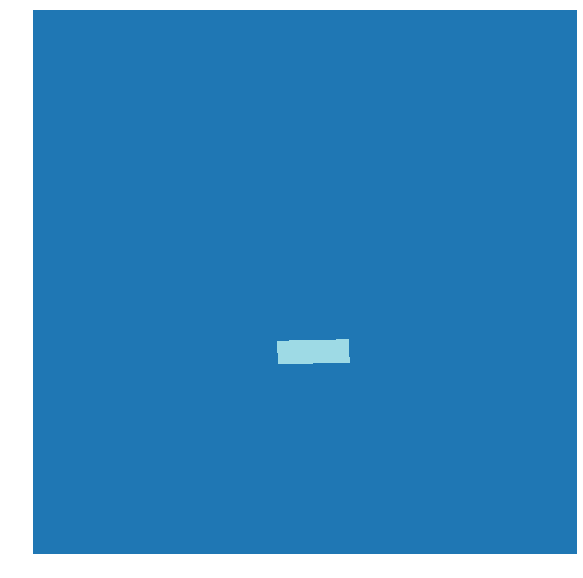

In [39]:
mask = get_mask(train_img_path/img_with_mask)
mask.show(figsize=(10,10), alpha=1)

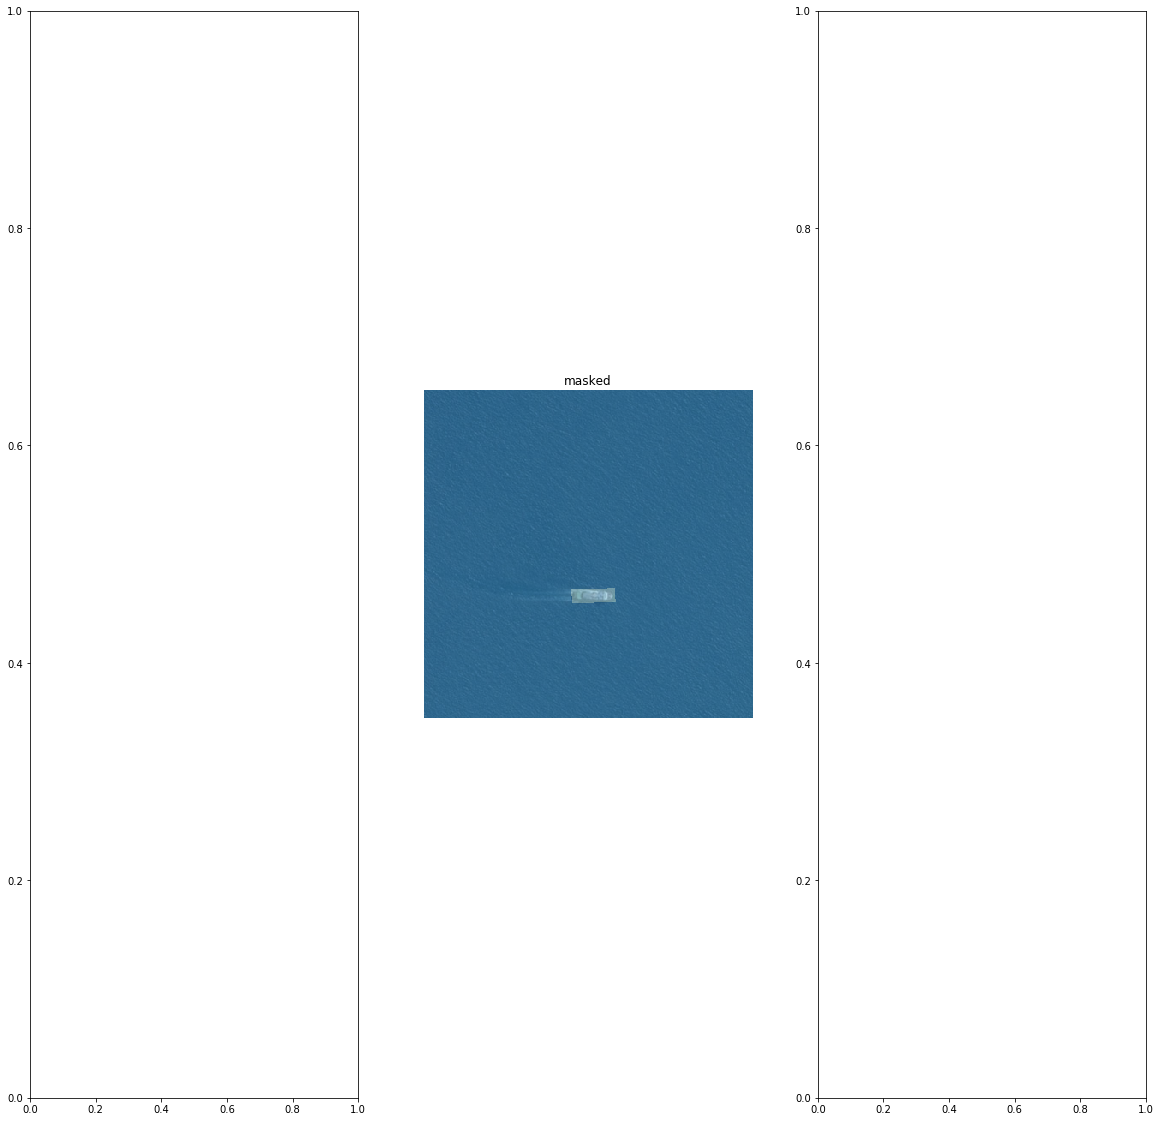

In [40]:
img = open_image(train_img_path/img_with_mask).resize(size)
_,axs = plt.subplots(1,3, figsize=(20,20))
img.show(ax=axs[1], y=mask, title='masked')

In [41]:
def rle_encode_vert(img:NPArrayMask)->str:
    pixels = np.concatenate([[0] , img.transpose(1, 2).flatten(), [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [42]:
train_mask_

'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

## encode function

In [43]:
rle_encoded = rle_encode_vert(mask.resize((1,original_shape,original_shape)).data); rle_encoded

'264661 16 265429 16 266197 32 266965 32 267733 32 268501 32 269269 32 270037 32 270805 32 271573 32 272341 32 273109 32 273877 32 274645 32 275413 32 276181 32 276949 32 277717 32 278483 34 279251 34 280019 34 280787 34 281555 34 282323 34 283091 34 283859 34 284627 34 285395 34 286163 34 286931 34 287699 34 288467 34 289235 34 290003 34 290771 34 291539 34 292307 34 293075 34 293843 34 294611 34 295379 34 296147 34 296915 34 297683 34 298451 34 299219 34 299987 34 300755 34 301523 34 302291 34 303059 34 303827 34 304595 32 305363 32 306131 32 306899 32 307667 32 308435 32 309203 32 309971 32 310739 32 311507 32 312275 32 313043 32 313811 32 314579 32 315347 32 316115 32 316883 32 317651 32 318419 32 319187 32 319955 32 320723 32 321491 32 322259 32 323027 32 323795 32 324563 32 325331 32 326099 32 326867 32 327635 32 328403 32 329169 34 329937 34 330705 34 331473 34 332241 34 333009 34 333777 34 334545 34 335313 34 336081 34 336849 34 337617 34 338385 34 339153 34 339921 34 340689 34

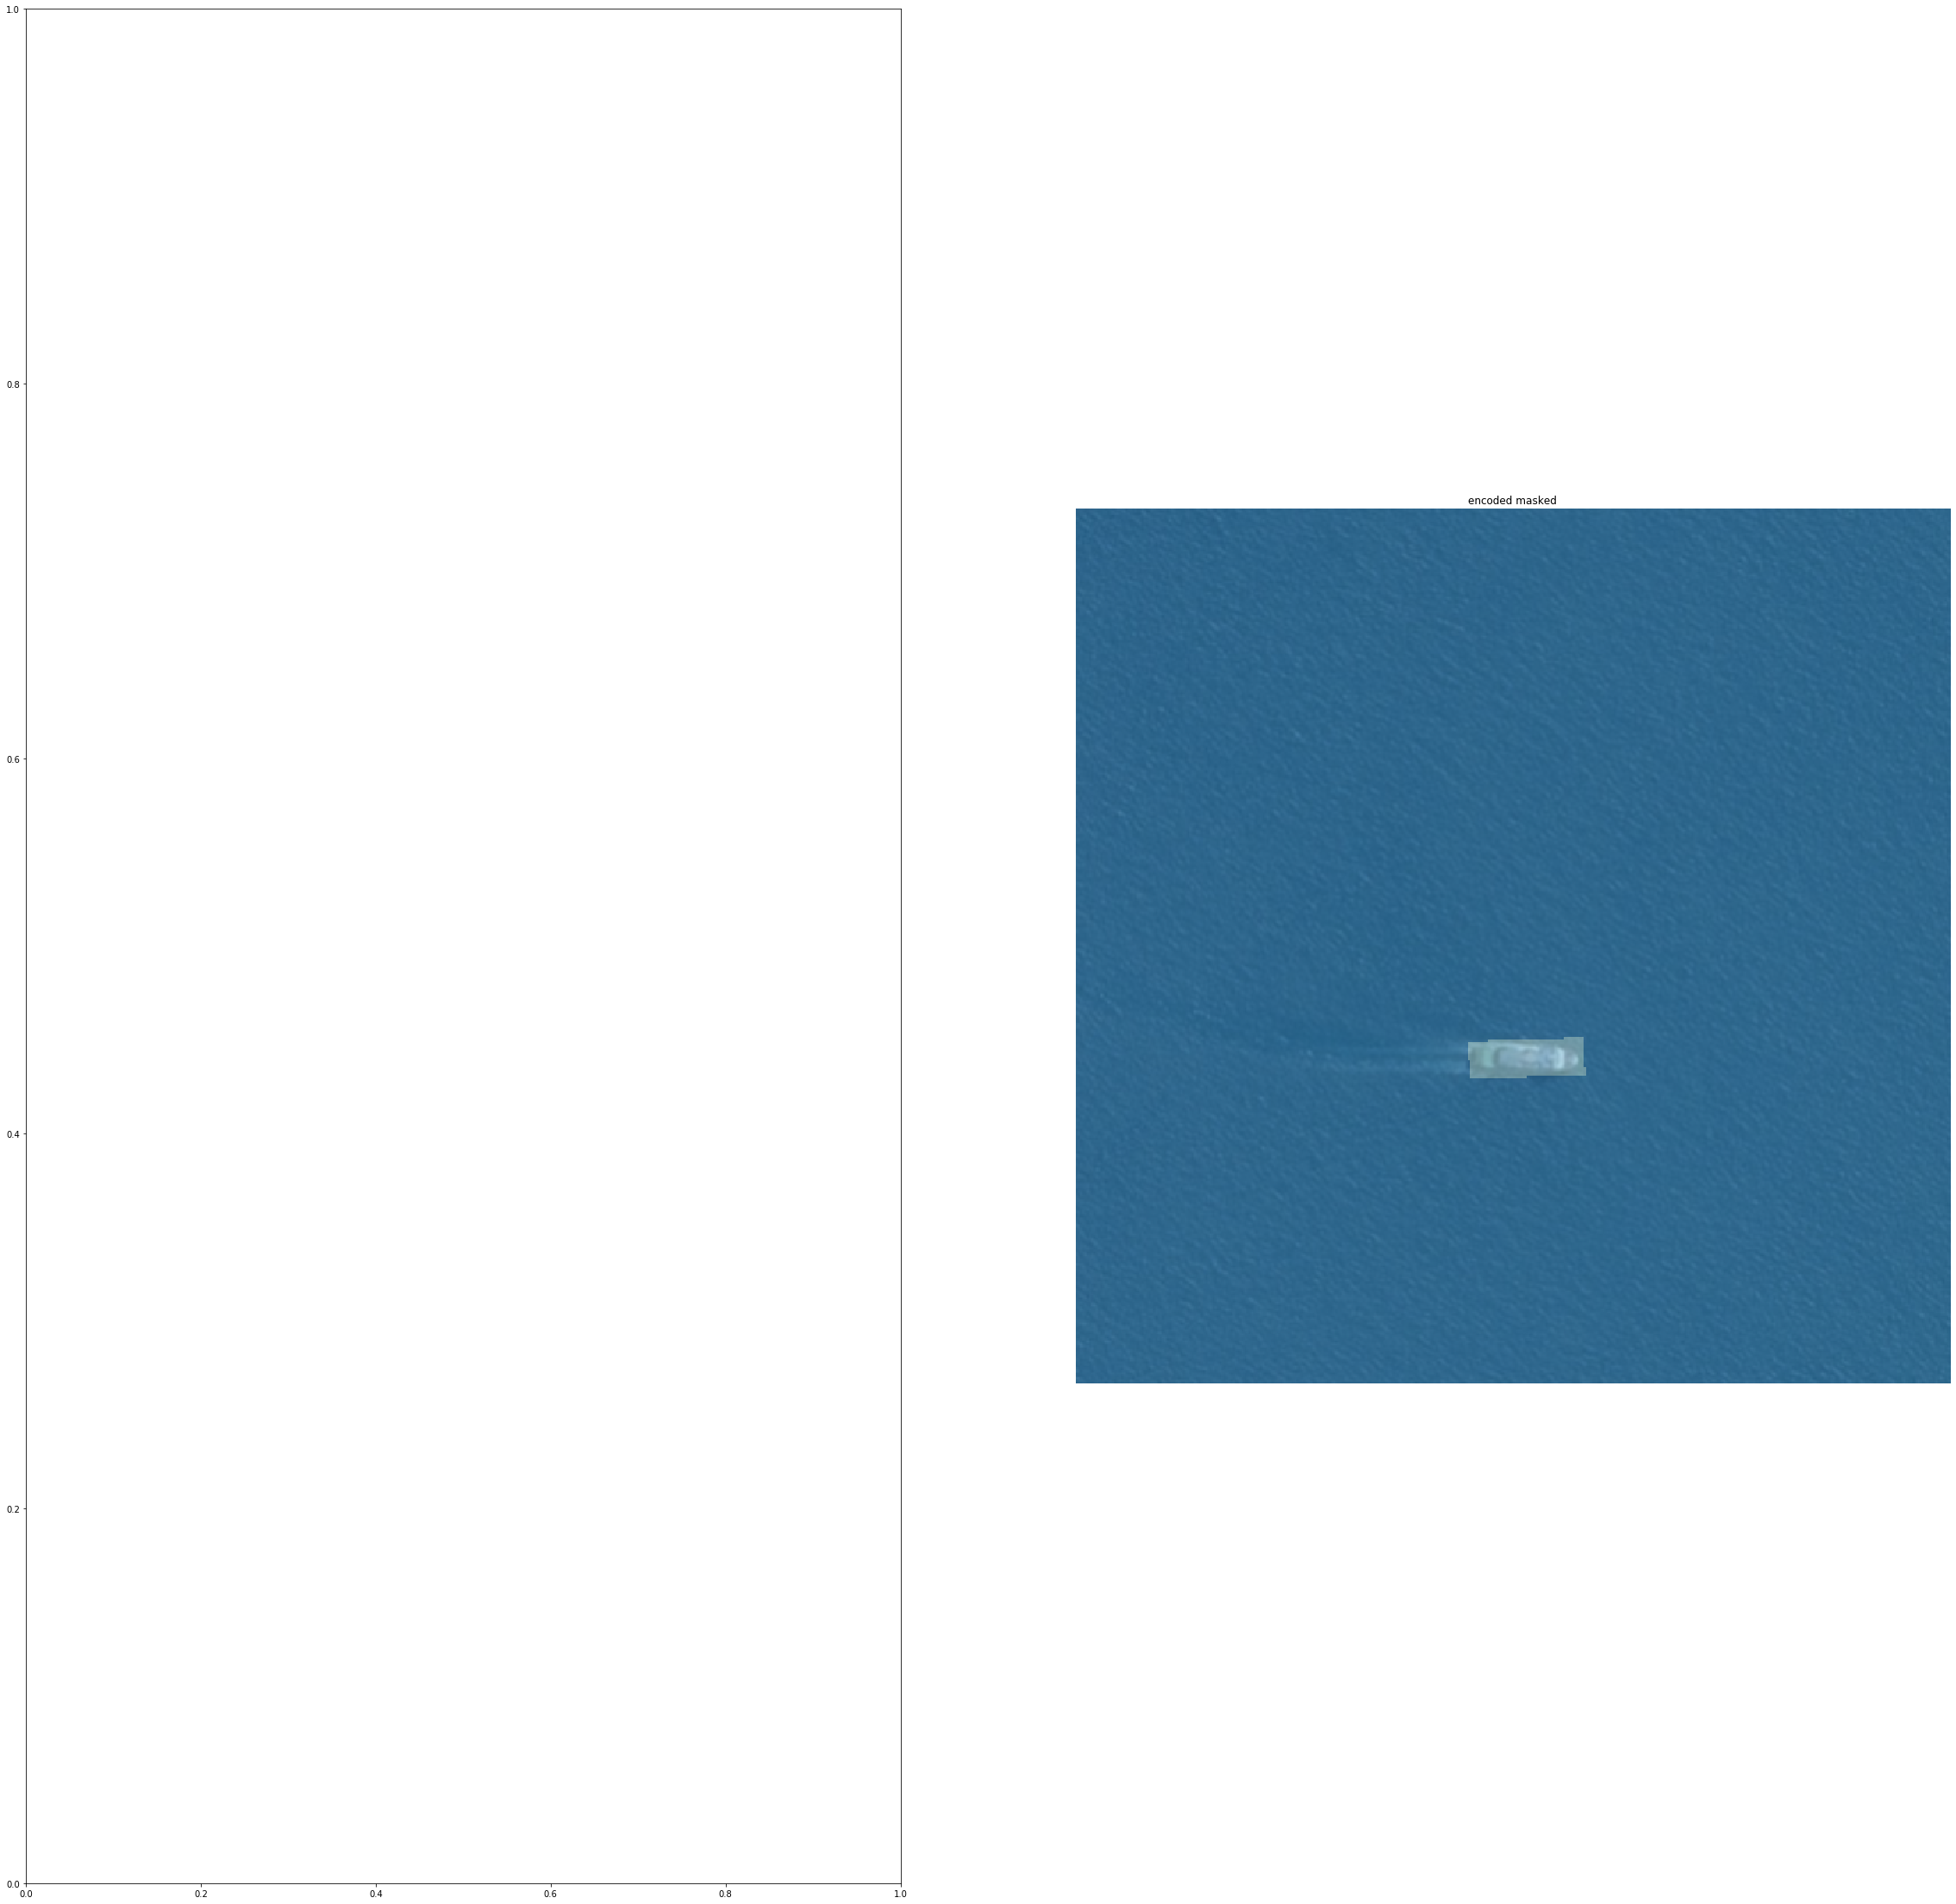

In [44]:
mask_encoded =  open_mask_rle_vert(rle_encoded, shape=(original_shape, original_shape));
_,axs = plt.subplots(1,2, figsize=(40,40))
img.resize(original_shape).show(ax=axs[1], y=mask_encoded, title='encoded masked')

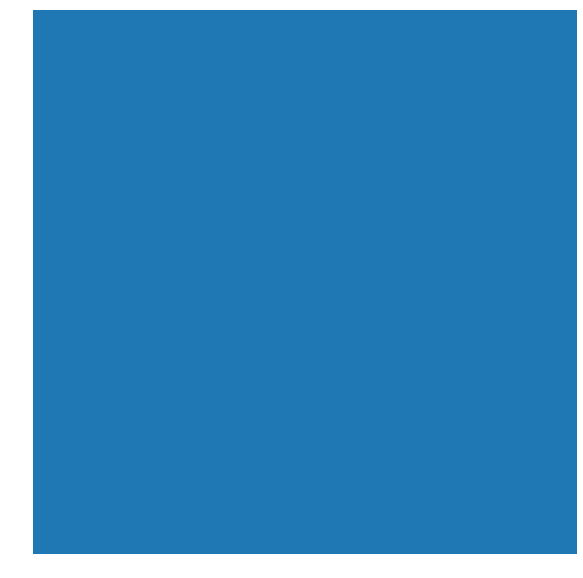

In [45]:
# empty mask
img_wo_ship=train_img_path/'00003e153.jpg'
mask = get_mask(img_wo_ship)
mask.show(figsize=(10,10), alpha=1)

In [46]:
rle_encode_vert(mask.data)

''

We do not have enough mem to predict mask - using fact that there are much more imgs w/o ships - at first 
train to ship detecton

## Ship detection

In [50]:
seed = 128

In [51]:
bs,size = 8,384

In [52]:
def contains_ship_f(x): 
    mask_str = train_mask_img_indexed.loc[x.name]['EncodedPixels']
    if(type(mask_str) == float): 
        return 'no_ships'
    else:
        return 'some_ships'

at first in small subset

In [53]:
train_img_path = path/'train_small'

In [54]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [57]:
src = (ImageList.from_folder(train_img_path)
       .split_by_rand_pct(valid_pct=0.2, seed=seed)
       .label_from_func(contains_ship_f))

In [58]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

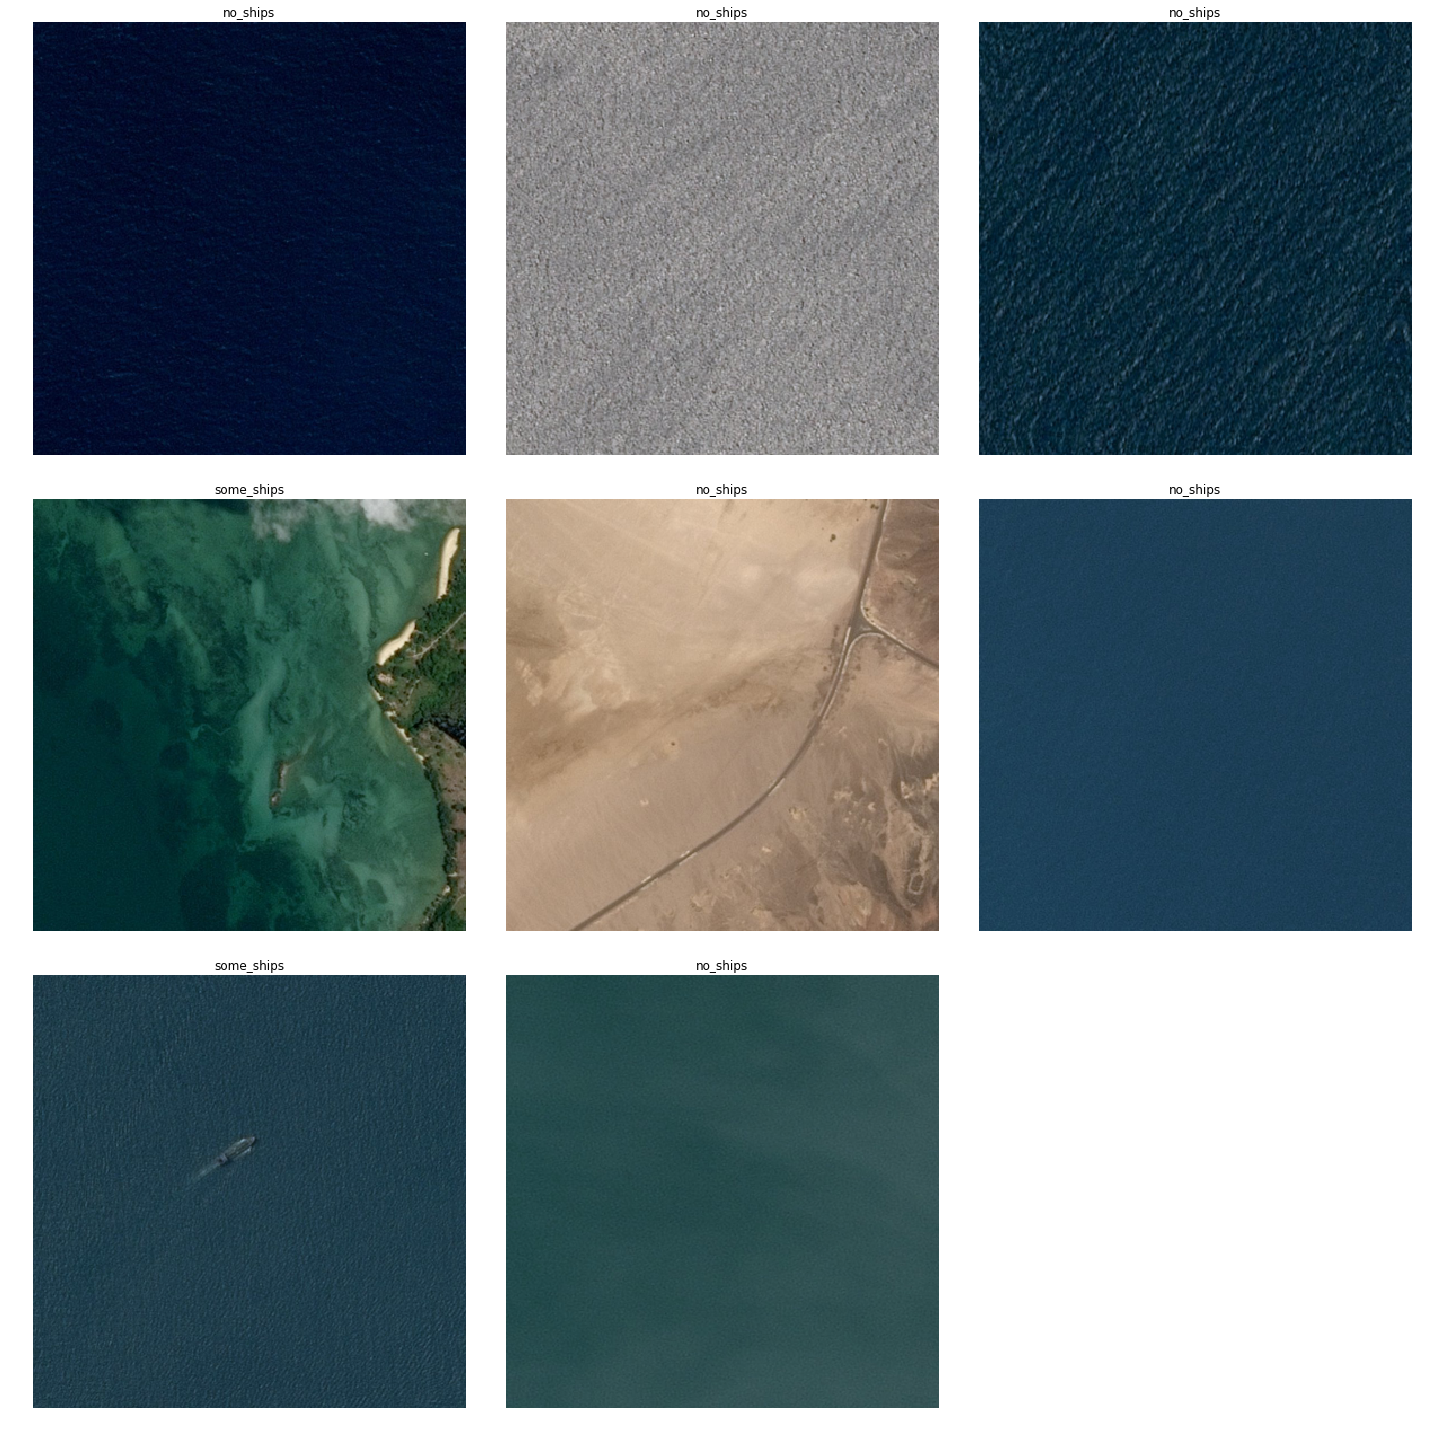

In [62]:
data.show_batch(4, figsize=(20,20))

In [55]:
arch = models.resnet50

In [59]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[accuracy])

In [65]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


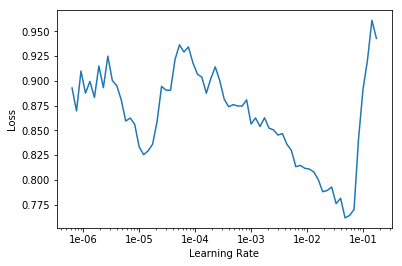

In [66]:
learn.recorder.plot()

In [60]:
lr = 0.01

In [72]:
learn.fit_one_cycle(5, slice(lr))

accuracy is pretty good, let's improve on full data set and bigger resolutuons

## Training for img on full dataset with higher resolution

In [62]:
train_img_path = path/'train_v2'

In [63]:
ship_detection_learning_384_data = (ImageList.from_folder(train_img_path)
        .split_by_rand_pct(valid_pct=0.2, seed=seed)
        .label_from_func(contains_ship_f)
        .transform(tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [64]:
ship_detection_learning_384_data.save('ship_detection_learning_384_data')

In [ ]:
ship_detection_learning_384_data = cnn_learner(data, arch, metrics=[accuracy])

## Training for img with ships to create mask

## Submitting results to kaggle

In [73]:
len(learn.data.test_ds)

418

In [80]:
row = test_csv_pd.iloc[0]

In [89]:
learn.export()

In [90]:
test = TabularList.from_df(test_csv_pd, path=path, cat_names=cat_names,
                                 cont_names=cont_names)

In [91]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [92]:
data_classes = [learn.data.classes[pred.argmax().item()] for pred in preds]

In [94]:
data_classes[1]

0

In [74]:
submission = pd.DataFrame(columns=['PassengerId', 'Survived']); submission.head()

Empty DataFrame
Columns: [PassengerId, Survived]
Index: []

In [96]:
submission['PassengerId'] = test_csv_pd['PassengerId']; submission.head()

PassengerId Survived
0          892      NaN
1          893      NaN
2          894      NaN
3          895      NaN
4          896      NaN

In [97]:
submission['Survived'] = data_classes; submission.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [98]:
submission.to_csv(path/'submission04262019.csv', index=False)

In [99]:
! kaggle competitions submit titanic -f {path/'submission04262019.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 4.47kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster